In [537]:
%config IPCompleter.greedy=True
from queue import *

In [538]:
class IndependentSet():
    def __init__(self, g):
        self.G = Graph(g.order())

    def I(self):
        return self.G.edges()

In [539]:
# https://medium.com/100-days-of-algorithms/day-41-union-find-d0027148376d
def find(data, i):
    if i != data[i]:
        data[i] = find(data, data[i])
    return data[i]

def union(data, i, j):
    pi, pj = find(data, i), find(data, j)
    if pi != pj:
        data[pi] = pj

In [540]:
def rootTree(self, root, treenumber, I):
    d = DiGraph()
    q = Queue()
    q.put(root)
    levelordernumber = 0
    
    while not q.empty():
        v = q.get()
        levelordernumber += 1
        I.Levelordernumbers[v] = levelordernumber
        I.Visited[v] = True
        I.Treenumbers[v] = treenumber
        
        for n in self.neighbor_iterator(v):
            if not I.Visited[n]:
                d.add_edge(v,n)
                q.put(n)
                
    return d
        
Graph.rootTree = rootTree

In [541]:
def c_graphic((a,b), I):
    if I.Treenumbers[a] != I.Treenumbers[b]:
        return None
    
    cycle = []
    tree = I.Trees[I.Treenumbers[a]]
    while a != b:
        node = a if I.Levelordernumbers[a] > I.Levelordernumbers[b] else b
        parent = tree.neighbors_in(node)[0]
        if find(I.Disjointsets, parent) != find(I.Disjointsets, node):
            cycle.append((parent, node))
            union(I.Disjointsets, parent, node)
        if I.Levelordernumbers[a] > I.Levelordernumbers[b]:
            a = parent
        else:
            b = parent
    
    return cycle

In [542]:
def start_graphic(Is):
    for I in Is:
        I.Treenumbers = [0] * I.G.order()
        I.Trees = list()
        I.Levelordernumbers = [0] * I.G.order()
        I.Visited = [False] * I.G.order()
        I.Disjointsets = [i for i in range(I.G.order())]
        components = I.G.connected_components_subgraphs()
        for idx, c in enumerate(components):
            rootedTree = c.rootTree(c.vertices()[0], idx, I)
            I.Trees.append(rootedTree)

In [543]:
def cyclic_scanning(es, k, labels, Is, c):
    q = Queue()
    map(q.put, es)
    while not q.empty():
        e = q.get()
        (_,i) = labels[e]
        i = (i + 1) % k
        cycle = c(e, Is[i])
        if cycle == None:
            return ((e,i), labels)
        for f in cycle:
            labels[f] = (e, i)
            q.put(f)
    return (None, labels)

In [544]:
def k_forest(g, k, start, c):
    Is = [IndependentSet(g) for i in range(k)]
    
    removedEdges = []
    for v in filter(lambda v: g.degree(v) <= k, g.vertices()):
        for idx, e in enumerate(g.edges_incident([v], labels = False)):
            removedEdges.append(e + (idx,))
        g.delete_vertex(v)
  
    start(Is)
    label = None
    for e in g.edges(labels = False):
        labels = {}
        labels[e] = (e,-1)
        if label != None:
            start(Is)
        (label, labels) = cyclic_scanning([e], k, labels, Is, c)
        if label != None:
            (f,i) = label
            while i != -1:
                Is[i].G.add_edge(f + (i,))
                if f != e:
                    i = (i - 1) % k
                    Is[i].G.delete_edge(f + (i,))
                (f,i) = labels[f]
    
    for (a, b, idx) in removedEdges:
        Is[idx].G.add_edge((a, b, idx))
        g.add_edge((a, b, idx))  
        
    return Is

In [545]:
def top_clump(g, k, start, c):
    L = []
    B = []
    Is = k_forest(g, k, start, c)
    for i in range(k):
        B += Is[i].I()
    for e in B:
        start(Is)
        labels = {}
        labels[e[:2]] = (e,-1)
        (label, labels) = cyclic_scanning([e[:2]], k, labels, Is, c)
        if label == None:
            L.append(e)
    return L

14


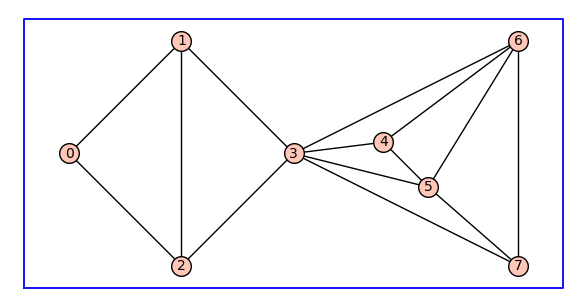

13


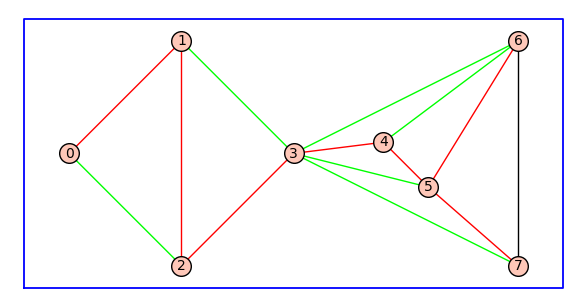

In [546]:
graph = Graph(8) #Graph({0: [1], 1: [2,3], 3: [4,5]})
graph.add_edge(0,1)
graph.add_edge(0,2)
graph.add_edge(1,2)
graph.add_edge(2,3)
graph.add_edge(1,3)
graph.add_edge(3,6)
graph.add_edge(3,4)
graph.add_edge(3,5)
graph.add_edge(3,7)
graph.add_edge(4,5)
graph.add_edge(5,7)
graph.add_edge(4,6)
graph.add_edge(5,6)
graph.add_edge(7,6)
pos = {0:[0.0, 0.0], 1:[1.0, 1.0], 2:[1.0, -1.0], 3:[2.0, 0.0], 4:[2.8, 0.1], 5:[3.2, -0.3], 6:[4.0, 1.0], 7:[4.0, -1.0]}

#graph = graphs.CycleGraph(9)
#pos = graph.layout().copy()

#graph = graphs.PoussinGraph()
#pos = graph.layout()

#graph = graphs.FruchtGraph()
#pos = graph.layout()

#graph = graphs.GoldnerHararyGraph()
#graph.delete_edge((1,3,None))
#pos = graph.layout()

#graph = graphs.HerschelGraph()
#pos = graph.layout()

#graph = graphs.WienerArayaGraph()
#pos = graph.layout()

print (len(graph.edges()))
p = graph.plot(vertex_labels=True, graph_border=True, pos=pos)
p.show()

Is = k_forest(graph, 2, start_graphic, c_graphic)
l1 = Is[0].I()
l2 = Is[1].I()
l = l1 + l2
print(len(l))
res1 = set(map(lambda x: x[:2], graph.edges()))
res2 = set(map(lambda x: x[:2], l))
res = res1.difference(res2)
r = map(lambda x: x + (-1,), list(res))
output = Graph(4)
output.add_edges(r + l)
pp = output.plot(vertex_labels=True, graph_border=True, color_by_label={0:(1,0,0), 1:(0,1,0)}, pos=pos)
pp.show()

8


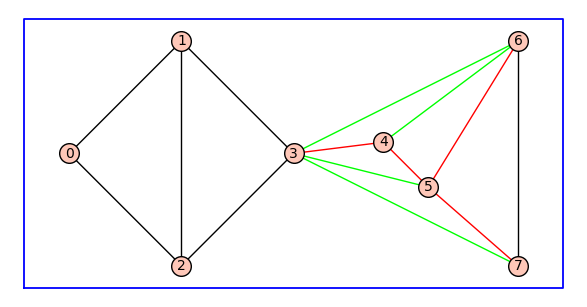

In [547]:
L = top_clump(graph, 2, start_graphic, c_graphic)
print(len(L))
res1 = set(map(lambda x: x[:2], graph.edges()))
res2 = set(map(lambda x: x[:2], L))
res = res1.difference(res2)
r = map(lambda x: x + (-1,), list(res))
gg = Graph({})
gg.add_edges(r + L)
p = gg.plot(vertex_labels=True, graph_border=True, color_by_label={0:(1,0,0), 1:(0,1,0)}, pos=pos)
p.show()

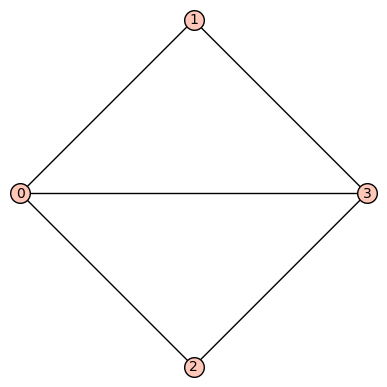

5


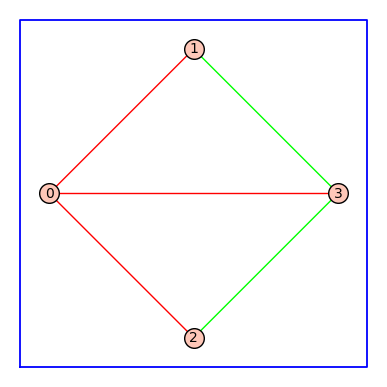

In [548]:
g4 = Graph(4) #Graph({0: [1], 1: [2,3], 3: [4,5]})
g4.add_edge(0,1, 100)
g4.add_edge(0,2, 100)
g4.add_edge(0,3, 1)
g4.add_edge(2,3, 100)
g4.add_edge(1,3, 1)
g4.weighted(True)
pos = {0:[0.0, 0.0], 1:[1.0, 1.0], 2:[1.0, -1.0], 3:[2.0, 0.0]}
p = g4.plot(pos = pos)
p.show()
Is = k_forest(g4, 2, start_graphic, c_graphic)
l1 = Is[0].I()
l2 = Is[1].I()
l = l1 + l2
print(len(l))
res1 = set(map(lambda x: x[:2], g4.edges()))
res2 = set(map(lambda x: x[:2], l))
res = res1.difference(res2)
r = map(lambda x: x + (-1,), list(res))
output = Graph(4)
output.add_edges(r + l)
pp = output.plot(vertex_labels=True, graph_border=True, color_by_label={0:(1,0,0), 1:(0,1,0)}, pos=pos)
pp.show()

In [483]:
graph.delete_edge((2,3,100))
graph.edge_cut(2,3, value_only=False, use_edge_labels = True)

[2, [(0, 3, 1), (1, 3, 1)]]

In [522]:
def start_dual(Is):
    for I in Is:
        I.Treenumbers = [0] * I.G.order()
        I.Trees = list()
        I.Levelordernumbers = [0] * I.G.order()
        I.Visited = [False] * I.G.order()
        I.Disjointsets = [i for i in range(I.G.order())]
        components = I.G.connected_components_subgraphs()
        for idx, c in enumerate(components):
            rootedTree = c.rootTree(c.vertices()[0], idx, I)
            I.Trees.append(rootedTree)

In [535]:
def top_clump_dual(g, k, start, c, start_dual, c_dual):
    L = []
    B = []
    A = []
    Is = k_forest(g, k, start, c)
    start(Is)
    for i in range(k):
        for e in Is[i].I():
            for j in range(i + 1, i + k):
                j = j % k
                if c(e[:2], Is[j]) == None:
                    A.append(e)
                    break
    start_dual(Is)
    (label, labels) = cyclic_scanning(A, k, {}, Is, c_dual)
    return L

In [536]:
A = top_clump_dual(g4, 2, start_graphic, c_graphic, start_dual, None)
print (A)

TypeError: unhashable type: 'list'